In [1]:
import torch
import torch.nn as nn
import torchvision.models as models

class Backbone(nn.Module):
    def __init__(self):
        super(Backbone, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=True)
        print('Base model loaded: MobileNetV2')

        self.block1 = nn.Sequential(*list(self.base_model.features[:5]))
        self.block2 = nn.Sequential(*list(self.base_model.features[5:8]))
        self.block4 = nn.Sequential(*list(self.base_model.features[8:15]))
        self.block7 = nn.Sequential(*list(self.base_model.features[15:17]))
        self.block14 = nn.Sequential(*list(self.base_model.features[17:-1]))

    def forward(self, x):
        features_block1 = self.block1(x)
        features_block2 = self.block2(features_block1)
        features_block4 = self.block4(features_block2)
        features_block7 = self.block7(features_block4)
        features_block14 = self.block14(features_block7)

        return features_block1, features_block2, features_block4, features_block7, features_block14






In [2]:
import torch.nn as nn
import torch
import math

class BiFPN(nn.Module):
    def __init__(self,  fpn_sizes):
        super(BiFPN, self).__init__()

        P3_channels, P4_channels, P5_channels, P6_channels, P7_channels = fpn_sizes
        self.W_bifpn = 64

        #self.p6_td_conv  = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_conv  = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_td_conv_2  = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_act   = nn.ReLU()
        self.p6_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p5_td_conv  = nn.Conv2d(P5_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p5_td_conv_2  = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p5_td_act   = nn.ReLU()
        self.p5_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p4_td_conv  = nn.Conv2d(P4_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p4_td_conv_2  = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p4_td_act   = nn.ReLU()
        self.p4_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_td_w1    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_td_w2    = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_upsample   = nn.Upsample(scale_factor=2, mode='nearest')


        self.p3_out_conv = nn.Conv2d(P3_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p3_out_conv_2 = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p3_out_act   = nn.ReLU()
        self.p3_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p3_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_upsample  = nn.Upsample(scale_factor=2, mode='nearest')

        #self.p4_out_conv = nn.Conv2d(P4_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p4_out_conv = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p4_out_act   = nn.ReLU()
        self.p4_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_downsample= nn.MaxPool2d(kernel_size=2)

        #self.p5_out_conv = nn.Conv2d(P5_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p5_out_conv = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p5_out_act   = nn.ReLU()
        self.p5_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_downsample= nn.MaxPool2d(kernel_size=2)

        #self.p6_out_conv = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_out_conv = nn.Conv2d(self.W_bifpn, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_out_act   = nn.ReLU()
        self.p6_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w3   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        #self.p4_downsample= nn.MaxPool2d(kernel_size=2)


        self.p7_out_conv = nn.Conv2d(P7_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p7_out_conv_2 = nn.Conv2d(self.W_bifpn,self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p7_out_act  = nn.ReLU()
        self.p7_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p7_out_w1   = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p7_out_w2   = torch.tensor(1, dtype=torch.float, requires_grad=True)


    def forward(self, inputs):
        epsilon = 0.0001
        P3, P4, P5, P6, P7 = inputs
        #print ("Input::", P3.shape, P4.shape, P5.shape, P6.shape, P7.shape)
        #P6_td = self.p6_td_conv((self.p6_td_w1 * P6 ) /
        #                         (self.p6_td_w1 + epsilon))

        P7_td  = self.p7_out_conv(P7)

        P6_td_inp = self.p6_td_conv(P6)
        P6_td = self.p6_td_conv_2((self.p6_td_w1 * P6_td_inp + self.p6_td_w2 * P7_td) /
                                 (self.p6_td_w1 + self.p6_td_w2 + epsilon))
        #P6_td = self.p6_td_conv_2(P6_td_inp)
        P6_td = self.p6_td_act(P6_td)
        P6_td = self.p6_td_conv_bn(P6_td)


        P5_td_inp = self.p5_td_conv(P5)
        #print (P5_td_inp.shape, P6_td.shape)
        P5_td = self.p5_td_conv_2((self.p5_td_w1 * P5_td_inp + self.p5_td_w2 * P6_td) /
                                 (self.p5_td_w1 + self.p5_td_w2 + epsilon))
        P5_td = self.p5_td_act(P5_td)
        P5_td = self.p5_td_conv_bn(P5_td)

        #print (P4.shape, P5_td.shape)
        P4_td_inp = self.p4_td_conv(P4)
        P4_td = self.p4_td_conv_2((self.p4_td_w1 * P4_td_inp + self.p4_td_w2 * self.p5_upsample(P5_td)) /
                                 (self.p4_td_w1 + self.p4_td_w2 + epsilon))
        P4_td = self.p4_td_act(P4_td)
        P4_td = self.p4_td_conv_bn(P4_td)


        P3_td  = self.p3_out_conv(P3)
        P3_out = self.p3_out_conv_2((self.p3_out_w1 * P3_td + self.p3_out_w2 * self.p4_upsample(P4_td)) /
                                 (self.p3_out_w1 + self.p3_out_w2 + epsilon))
        P3_out = self.p3_out_act(P3_out)
        P3_out = self.p3_out_conv_bn(P3_out)

        #print (P4_td.shape, P3_out.shape)

        P4_out = self.p4_out_conv((self.p4_out_w1 * P4_td_inp  + self.p4_out_w2 * P4_td + self.p4_out_w3 * self.p3_downsample(P3_out) )
                                    / (self.p4_out_w1 + self.p4_out_w2 + self.p4_out_w3 + epsilon))
        P4_out = self.p4_out_act(P4_out)
        P4_out = self.p4_out_conv_bn(P4_out)


        P5_out = self.p5_out_conv(( self.p5_out_w1 * P5_td_inp + self.p5_out_w2 * P5_td + self.p5_out_w3 * self.p4_downsample(P4_out) )
                                    / (self.p5_out_w2 + self.p5_out_w3 + epsilon))
        P5_out = self.p5_out_act(P5_out)
        P5_out = self.p5_out_conv_bn(P5_out)


        P6_out = self.p6_out_conv((self.p6_out_w1 * P6_td_inp + self.p6_out_w2 * P6_td + self.p6_out_w3 * (P5_out) )
                                    / (self.p6_out_w1 + self.p6_out_w2 + self.p6_out_w3 + epsilon))
        P6_out = self.p6_out_act(P6_out)
        P6_out = self.p6_out_conv_bn(P6_out)


        P7_out = self.p7_out_conv_2((self.p7_out_w1 * P7_td + self.p7_out_w2 * P6_out) /
                                 (self.p7_out_w1 + self.p7_out_w2 + epsilon))
        P7_out = self.p7_out_act(P7_out)
        P7_out = self.p7_out_conv_bn(P7_out)


        return [P3_out, P4_out, P5_out, P6_out, P7_out]

In [3]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F

class UpSample(nn.Sequential):
    def __init__(self, skip_input, output_features):
        super(UpSample, self).__init__()        
        self.convA = nn.Conv2d(skip_input, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluA = nn.LeakyReLU(0.2)
        self.convB = nn.Conv2d(output_features, output_features, kernel_size=3, stride=1, padding=1)
        self.leakyreluB = nn.LeakyReLU(0.2)

    def forward(self, x, concat_with):
        up_x = F.interpolate(x, size=[concat_with.size(2), concat_with.size(3)], mode='bilinear', align_corners=True)
        return self.leakyreluB( self.convB( self.convA( torch.cat([up_x, concat_with], dim=1)  ) )  )

class Decoder(nn.Module):
    def __init__(self, num_features=64, decoder_width = 1.0):
        super(Decoder, self).__init__()
        features = int(num_features * decoder_width)

        self.conv2 = nn.Conv2d(num_features, features, kernel_size=1, stride=1, padding=0)

        self.up1 = UpSample(skip_input=features//1 + 64, output_features=features//2)
        self.up2 = UpSample(skip_input=features//2 + 64,  output_features=features//4)
        self.up3 = UpSample(skip_input=features//4 + 64,  output_features=features//8)
        self.up4 = UpSample(skip_input=features//8 + 64,  output_features=features//16)

        self.conv3 = nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding=1)

    def forward(self, features):
        x_block0, x_block1, x_block2, x_block3, x_block4 = features[0], features[1], features[2], features[3], features[4]
        x_d0 = self.conv2(F.relu(x_block4))

        x_d1 = self.up1(x_d0, x_block3)
        x_d2 = self.up2(x_d1, x_block2)
        x_d3 = self.up3(x_d2, x_block1)
        x_d4 = self.up4(x_d3, x_block0)
        output = F.interpolate(x_d4, size=(480, 640), mode='bilinear', align_corners=True)

        return self.conv3(output)





In [4]:
class Depth_Model(nn.Module):
    def __init__(self):
        super(Depth_Model, self).__init__()
        self.back = Backbone()
        self.fusion = BiFPN([32, 64, 160, 160, 320])
        self.decoder = Decoder()

    def forward(self, x):
        features = self.back(x)
        fused_features = self.fusion(features)
        output = self.decoder(fused_features)
        return output

In [ ]:
!pip install kornia

In [ ]:
import torch
import kornia.metrics as metrics
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from torch.autograd import Variable

def ssim(
    img1: torch.Tensor,
    img2: torch.Tensor,
    window_size: int,
    max_val: float = 100.0,
    eps: float = 1e-12,
    reduction: str = 'mean',
    padding: str = 'same',
) -> torch.Tensor:
    # Compute the SSIM map
    ssim_map = metrics.ssim(img1, img2, window_size, max_val, eps, padding)

    # Compute and reduce the loss
    loss = torch.clamp((1.0 - ssim_map) / 2, min=0, max=1)

    if reduction == 'mean':
        loss = torch.mean(loss)
    elif reduction == 'sum':
        loss = torch.sum(loss)
    elif reduction == 'none':
        pass

    return loss

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd
from sklearn.utils import shuffle
import os

class NYUV2Dataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, base_dir, output_shape, transform=None):
        self.data = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.output_shape = output_shape
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rgb_path = os.path.join(self.base_dir, self.data.iloc[idx, 0])
        depth_path = os.path.join(self.base_dir, self.data.iloc[idx, 1])
        
        rgb_image = Image.open(rgb_path).convert('RGB')
        depth_image = Image.open(depth_path).convert('L')
        
        # Resize the depth image
        depth_image = depth_image.resize((self.output_shape[3], self.output_shape[2]))
        
        if self.transform is not None:
            rgb_image = self.transform(rgb_image)
        
        depth_transform = transforms.Compose([
            transforms.ToTensor()
        ])
        depth_image = depth_transform(depth_image)

        return rgb_image, depth_image



# Set the paths to the NYU v2 dataset CSV file and the corresponding RGB and depth images
csv_file = '/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train.csv'
base_dir = '/kaggle/input/nyu-depth-v2/nyu_data/'

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.Resize((480, 640)),
    transforms.ToTensor()
])
batch_size = 16
output_shape = (batch_size, 1, 480, 640)
nyu_dataset = NYUV2Dataset(csv_file, base_dir=base_dir, output_shape=output_shape, transform=transform)


# Create a data loader to load the dataset in batches

data_loader = torch.utils.data.DataLoader(nyu_dataset, batch_size=batch_size, shuffle=True)





model.load_state_dict(torch.load('/content/drive/MyDrive/kaggle/depth_model_epoch_6_v1_2.pth'))


In [5]:
model = Depth_Model().cuda()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 84.6MB/s]


Base model loaded: MobileNetV2


In [8]:
learning_rate = 0.0001
optimizer = torch.optim.Adam( model.parameters(), learning_rate )

In [6]:
def DepthNorm(depth, maxDepth=1000.0): 
    return maxDepth / depth


In [7]:
model.load_state_dict(torch.load('/kaggle/input/pegasisv3-35/pegasisv3_epoch_35.pth'))


<All keys matched successfully>

In [ ]:
from tqdm import tqdm

epochs = 5
l1_criterion = nn.L1Loss()

for epoch in range(epochs):
    total_loss = 0.0
    pbar = tqdm(data_loader, total=len(data_loader), desc=f"Epoch {epoch+1}/{epochs}")
    model.train()
    for batch in pbar:
        optimizer.zero_grad()
        inputs, targets = batch
        image = inputs.cuda()
        depth = targets.cuda(non_blocking=True)
        
        depth_n = DepthNorm( depth )

        output = model(image)
        output.shape
        depth_n.shape
        l_depth = l1_criterion(output, depth_n)
        l_ssim = torch.clamp((1 - ssim(output, depth_n, 5)) * 0.5, 0, 1)
        loss = (1.0 * l_ssim.mean().item()) + (0.1 * l_depth)
        print(l_ssim.mean().item(),l_depth)
        #loss = (1.0 * l_ssim) + (0.1 * l_depth)


        total_loss += loss.item()
        loss.backward()
        optimizer.step()

        pbar.set_postfix({'Loss': loss.item()})

    average_loss = total_loss / len(data_loader)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {average_loss:.4f}")

In [ ]:
# Save the weights of the model
torch.save(model.state_dict(), '/kaggle/working/pegasisv3_epoch_35.pth')


In [8]:
import torchvision.transforms as transforms
from PIL import Image

output_height, output_width = 480, 640

image = Image.open('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test/00014_colors.png')  # Replace 'your_image.jpg' with the path to your image
#image=Image.open('/content/1.jpg')
transform = transforms.Compose([
    transforms.Resize((output_height, output_width)),
    transforms.ToTensor()
])
image_tensor = transform(image)

image_tensor = image_tensor.unsqueeze(0)  # Add a batch dimension
image_tensor = image_tensor.permute(0, 2, 3, 1)  # Reshape from (1, 3, 480, 640) to (1, 480, 640, 3)
image_tensor = image_tensor.permute(0, 3, 1, 2)  # Reshape to the required shape (1, 3, 480, 640)
image_tensor = image_tensor.float()

In [12]:
import torchvision.transforms as transforms
from PIL import Image

output_height, output_width = 480, 640

image_1 = Image.open('/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_test/00014_depth.png')  # Replace 'your_image.jpg' with the path to your image
#image=Image.open('/content/1.jpg')
transform = transforms.Compose([
    transforms.Resize((output_height, output_width)),
    transforms.ToTensor()
])
image_tensor_1 = transform(image_1)

image_tensor_1 = image_tensor_1.unsqueeze(0)  # Add a batch dimension
image_tensor_1 = image_tensor_1.permute(0, 2, 3, 1)  # Reshape from (1, 3, 480, 640) to (1, 480, 640, 3)
image_tensor_1 = image_tensor_1.permute(0, 3, 1, 2)  # Reshape to the required shape (1, 3, 480, 640)
image_tensor_1= image_tensor_1.float()

In [9]:
with torch.no_grad():
    outputv3 = model(image_tensor.to("cuda"))

In [22]:
depth_np = DepthNorm( image_tensor_1 )

In [23]:
depth_np

tensor([[[[0.3482, 0.3482, 0.3483,  ..., 0.7067, 0.7067, 0.7067],
          [0.3482, 0.3482, 0.3483,  ..., 0.7067, 0.7067, 0.7067],
          [0.3481, 0.3481, 0.3482,  ..., 0.7067, 0.7072, 0.7072],
          ...,
          [0.5176, 0.5176, 0.5173,  ..., 0.7153, 0.7158, 0.7158],
          [0.5176, 0.5173, 0.5173,  ..., 0.7153, 0.7153, 0.7153],
          [0.5173, 0.5173, 0.5173,  ..., 0.7148, 0.7153, 0.7153]]]])

In [25]:
outputv3_np = DepthNorm(outputv3 )

In [35]:
outputv3_1=outputv3/1000

In [36]:
outputv3_1

tensor([[[[1.8693, 2.4451, 2.4849,  ..., 3.8082, 3.6833, 2.2711],
          [2.6236, 3.2389, 3.2808,  ..., 5.0411, 4.8793, 3.2757],
          [2.6450, 3.2429, 3.2777,  ..., 5.1362, 4.9835, 3.3463],
          ...,
          [4.4004, 5.2660, 5.3076,  ..., 6.5036, 6.3927, 4.2874],
          [4.4372, 5.2998, 5.3479,  ..., 6.4646, 6.3348, 4.2425],
          [3.0797, 3.4012, 3.4350,  ..., 4.0463, 3.9384, 2.6073]]]],
       device='cuda:0')

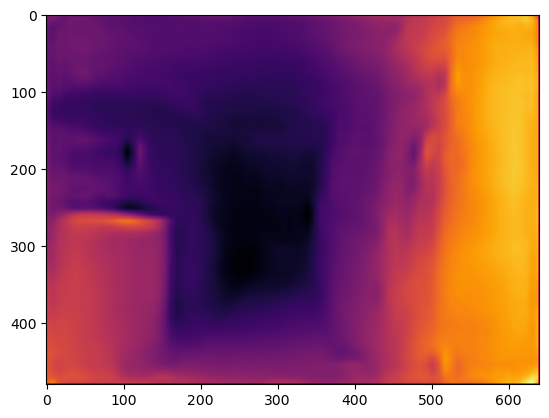

In [37]:
import matplotlib.pyplot as plt
output_reshaped = outputv3_1.squeeze().detach().cpu().numpy()
plt.imshow(output_reshaped, cmap='inferno')
#plt.imsave("/kaggle/working/pegasisv3_ep35.png",output_reshaped, cmap='inferno')

In [40]:
import torch
import torch.nn.functional as F

def siloge_loss(depth_pred, depth_gt):
    # Add a small epsilon to avoid division by zero
    epsilon = 1e-6

    # Logarithm of depth values
    log_depth_pred = torch.log(torch.clamp(depth_pred, min=epsilon))
    log_depth_gt = torch.log(torch.clamp(depth_gt, min=epsilon))

    # Calculate the SILogE loss
    siloge = torch.pow(log_depth_gt - log_depth_pred, 2).mean() - torch.pow(log_depth_gt.mean() - log_depth_pred.mean(), 2)

    return siloge

# Example usage:
# depth_pred and depth_gt are torch tensors representing the predicted depth and ground truth depth images, respectively.
loss = siloge_loss(outputv3_1, depth_np.to("cuda"))
print("SILogE Loss:", loss.item())

SILogE Loss: 0.05573129653930664


In [15]:
outputv3.

tensor([[[[1869.3442, 2445.1453, 2484.8867,  ..., 3808.2241, 3683.3252,
           2271.1025],
          [2623.6228, 3238.9026, 3280.8318,  ..., 5041.0908, 4879.3481,
           3275.6704],
          [2645.0029, 3242.9011, 3277.7134,  ..., 5136.1919, 4983.5337,
           3346.2866],
          ...,
          [4400.3711, 5265.9624, 5307.5605,  ..., 6503.6406, 6392.6865,
           4287.4385],
          [4437.1875, 5299.7593, 5347.9072,  ..., 6464.5625, 6334.8232,
           4242.4878],
          [3079.6970, 3401.2034, 3435.0337,  ..., 4046.2664, 3938.4124,
           2607.2720]]]], device='cuda:0')

In [32]:
depth_np.to("cuda")

tensor([[[[0.3482, 0.3482, 0.3483,  ..., 0.7067, 0.7067, 0.7067],
          [0.3482, 0.3482, 0.3483,  ..., 0.7067, 0.7067, 0.7067],
          [0.3481, 0.3481, 0.3482,  ..., 0.7067, 0.7072, 0.7072],
          ...,
          [0.5176, 0.5176, 0.5173,  ..., 0.7153, 0.7158, 0.7158],
          [0.5176, 0.5173, 0.5173,  ..., 0.7153, 0.7153, 0.7153],
          [0.5173, 0.5173, 0.5173,  ..., 0.7148, 0.7153, 0.7153]]]],
       device='cuda:0')